Here we use DTW to synchronize Audio and MIDI using their chroma features.

Shape of audio_chroma:  (12, 2412)
Shape of midi_chroma:  (12, 2194)


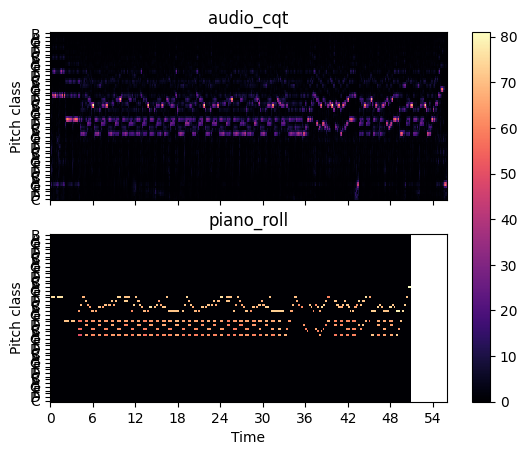

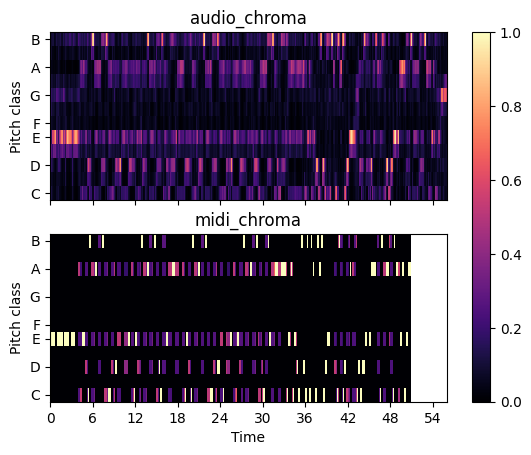

In [101]:
import librosa
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

# Load an audio file
audio_path = 'Disklavier_03_G1_B1.wav'
y, sr = librosa.load(audio_path)

# Load a MIDI file
midi_path = 'Score_03_G1_B1.mid'
midi_data = pretty_midi.PrettyMIDI(midi_path)

# Extract audio features (e.g., chroma)
FS = 50
HOP_LENGTH = int(sr/FS)
audio_chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=HOP_LENGTH)
audio_cqt = abs(librosa.cqt(y=y, sr=sr, hop_length=HOP_LENGTH))

# Extract MIDI features (e.g., chroma)

# midi_chroma = librosa.feature.chroma_cqt(C=piano_roll, sr=FS, hop_length=1)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    if np.sum(x, axis=0) == 0:
        return np.zeros_like(x)
    return x / np.sum(x, axis=0)

def manual_chroma(piano_roll: np.ndarray, start_note = 24):
    chroma = np.zeros((12, np.shape(piano_roll)[1]))
    for j in range(np.shape(piano_roll)[1]):
        for i in range(np.shape(piano_roll)[0]):
            chroma[(i + start_note) % 12][j] += piano_roll[i][j]
    return chroma

def apply_softmax(arr: np.ndarray):
    x = arr.T
    for i in range(len(x)):
        x[i] = softmax(x[i])
    return x.T
        
piano_roll = midi_data.get_piano_roll(fs=FS)[24:24+84]
midi_chroma = apply_softmax(manual_chroma(piano_roll))

audio_chroma = apply_softmax(audio_chroma)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.specshow(apply_softmax(audio_cqt), y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].set(title='audio_cqt')
ax[0].label_outer()
img = librosa.display.specshow(piano_roll, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='piano_roll')
fig.colorbar(img, ax=ax)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.specshow(apply_softmax(audio_chroma), y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].set(title='audio_chroma')
ax[0].label_outer()
img = librosa.display.specshow(midi_chroma, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='midi_chroma')
fig.colorbar(img, ax=ax)
#librosa.display.specshow(midi_chroma, y_axis='chroma', x_axis='time')

print("Shape of audio_chroma: ", np.shape(audio_chroma))
print("Shape of midi_chroma: ", np.shape(midi_chroma))

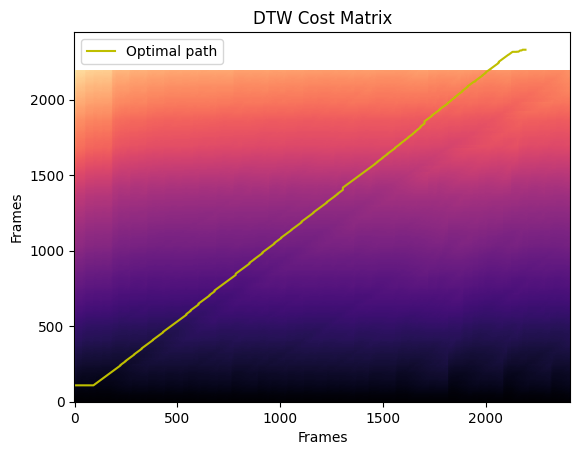

In [102]:
from librosa.sequence import dtw

# DTW alignment
D, wp = dtw(audio_chroma, midi_chroma, subseq=True, backtrack=True)

fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='frames', y_axis='frames', ax=ax)
ax.plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
ax.legend()
ax.set(title='DTW Cost Matrix')
plt.show()

In [103]:
import pretty_midi

# Assuming 'midi_data' is your loaded PrettyMIDI object and 'wp' is the DTW path
adjusted_midi = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(program=midi_data.instruments[0].program)

# Scaling factor: this depends on your specific frame rates and needs calibration
# scaling_factor = len(y) / len(piano_roll[0])
# https://librosa.org/doc/main/generated/librosa.feature.chroma_cqt.html, use argument hop_length

for note in midi_data.instruments[0].notes:
    # Find closest frame in the audio corresponding to the MIDI note start
    midi_frame = int(note.start * FS)
    # audio_frame = next(wp[i][0] for i in range(len(wp)) if wp[i][1] == midi_frame)
    audio_frame = wp[0][0]
    for i in range(len(wp)):
        if wp[i][1] <= midi_frame:
            audio_frame = wp[min(len(wp)-1, i+1)][0]
            break
    
    adjusted_start = audio_frame / FS  # Convert frame number back to time
    adjusted_end = adjusted_start + (note.end - note.start)  # keep original duration
    
    # print("Note start time", note.start, "; MIDI frame", midi_frame, "; audio frame", audio_frame, "; Adjusted start time", adjusted_start)

    # Add note to the new instrument track
    instrument.notes.append(pretty_midi.Note(start=adjusted_start, end=adjusted_end, velocity=note.velocity, pitch=note.pitch))

adjusted_midi.instruments.append(instrument)
adjusted_midi.write('adjusted_midi_file.mid')
